# PEFT(Parameter-Efficient Fine-Tuning) on Pre-trained Model with Batch Correction
In this tutorial, we demonstrate how to peft a pre-trained model on a new dataset for the batch correction task. We use the PBMC 10K dataset as an example and peft on the pre-trained model. 

We summarize the peft pipeline in the following steps, which can be used as a general recipe for peft on batch correction tasks and beyond: 

     1. Specify hyper-parameter setup for batch correction task
     
     2. Load and pre-process data
     
     3. Load the pre-trained scGPT model
     
     4. PEFT scGPT with task-specific objectives
     
     5. Evaluate PEFT scGPT


In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import argparse
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt import SubsetsBatchSampler
from scgpt.utils import set_seed, eval_scib_metrics, load_pretrained, PeftConfig, freeze_parameters, DownstreamTasks

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore", category=DeprecationWarning)

Global seed set to 0
/users/PCON0022/coffee19850519/ondemand/scGPT_prompt/tutorial_peft/../scgpt/model/model.py:22: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/ondemand/scGPT_prompt/tutorial_peft/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [2]:
hyperparameter_defaults = dict(
    seed=42,
    dataset_name="PBMC_10K",  # Dataset name
    do_train=True,  # Flag to indicate whether to do update model parameters during training
    load_model="../save/scGPT_human",  # Path to pre-trained model
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,  # DAR objective weight for batch correction
    mask_ratio=0.4,  # Default mask ratio
    epochs=15,  # Default number of epochs for peft
    n_bins=51,  # Default number of bins for value binning in data pre-processing
    lr=1e-4,  # Default learning rate for peft
    batch_size=32,  # Default batch size for peft
    layer_size=128,
    nlayers=4,
    nhead=4,  # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,  # Default dropout rate during model peft
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5,  # Default model evaluation interval
    log_interval=100,  # Default log interval
    fast_transformer=False,  # Default setting
    pre_norm=False,  # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
    peft="ENCODER"
    # Whether using Parameter-Efficient Fine-Tuning,
    # False to disable, HYBRID/ENCODER/TOKEN/PREFIX/LORA are available for selection
)

config = argparse.Namespace(**hyperparameter_defaults)
print(config)

set_seed(config.seed)

Namespace(seed=42, dataset_name='PBMC_10K', do_train=True, load_model='../save/scGPT_human', GEPC=True, ecs_thres=0.8, dab_weight=1.0, mask_ratio=0.4, epochs=15, n_bins=51, lr=0.0001, batch_size=32, layer_size=128, nlayers=4, nhead=4, dropout=0.2, schedule_ratio=0.9, save_eval_interval=5, log_interval=100, fast_transformer=False, pre_norm=False, amp=True, peft='ENCODER')


In [3]:
# settings for parameter efficient fine tuning
assert config.peft in [False, "HYBRID", "ENCODER", "TOKEN", "PREFIX", "LORA"]
peft_config = PeftConfig(peft_type=config.peft, use_default_settings=True).to_dict()

# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

n_hvg = 1200  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

In [4]:
dataset_name = config.dataset_name
save_dir = Path(f"./save/peft_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to save/peft_PBMC_10K-Aug14-08-46


## Step 2: Load and pre-process data

### 2.1 Load the PBMC 10K data
Note that we retain the common gene set between the data and the pre-trained model for further peft.


In [5]:
if dataset_name == "PBMC_10K":
    data_dir = Path("../data/batch_correction")
    adata = sc.read(data_dir / "PBMC10K.h5ad")  # 11990 × 3346
    # adata = scvi.data.pbmc_dataset()  
    ori_batch_col = "batch"
    adata.obs["celltype"] = adata.obs["str_labels"].astype("category")
    adata.var = adata.var.set_index("gene_symbols")
    data_is_raw = True

# make the batch category column
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
adata

AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'n_counts', 'batch', 'labels', 'str_labels', 'celltype', 'str_batch', 'batch_id'
    var: 'n_counts-0', 'n_counts-1', 'n_counts', 'gene_name'
    uns: 'cell_types'
    obsm: 'design', 'normalized_qc', 'qc_pc', 'raw_qc'

In [7]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will be overriden by the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size
    nhead = config.nhead
    nlayers = config.nlayers
    d_hid = config.layer_size

scGPT - INFO - match 3256/3346 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ../save/scGPT_human/best_model.pt, the model args will be overriden by the config ../save/scGPT_human/args.json.


### 2.3 Pre-process the data
We follow the standardized pipline of depth normalization, log normalization, and highly vairable gene (HVG) selection for data pre-processing. We further introduced value binning to obtain the relative expressions of each HVG.

In [8]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch" if dataset_name != "heart_cell" else None)


scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:248: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number


scGPT - INFO - Binning data ...


In [9]:
if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

### 2.4 Tokenize the input data for model peft

In [10]:
input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)


In [11]:
if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

In [12]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=True,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,
    include_zero_gene=True,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)



scGPT - INFO - train set number of samples: 10791, 
	 feature length: 1201
scGPT - INFO - valid set number of samples: 1199, 
	 feature length: 1201


In [13]:
def prepare_data(sort_seq_batch=False) -> Tuple[Dict[str, torch.Tensor]]:
    masked_values_train = random_mask_value(
        tokenized_train["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    masked_values_valid = random_mask_value(
        tokenized_valid["values"],
        mask_ratio=mask_ratio,
        mask_value=mask_value,
        pad_value=pad_value,
    )
    print(
        f"random masking at epoch {epoch:3d}, ratio of masked values in train: ",
        f"{(masked_values_train == mask_value).sum() / (masked_values_train - pad_value).count_nonzero():.4f}",
    )

    input_gene_ids_train, input_gene_ids_valid = (
        tokenized_train["genes"],
        tokenized_valid["genes"],
    )
    input_values_train, input_values_valid = masked_values_train, masked_values_valid
    target_values_train, target_values_valid = (
        tokenized_train["values"],
        tokenized_valid["values"],
    )

    tensor_batch_labels_train = torch.from_numpy(train_batch_labels).long()
    tensor_batch_labels_valid = torch.from_numpy(valid_batch_labels).long()

    if sort_seq_batch:
        train_sort_ids = np.argsort(train_batch_labels)
        input_gene_ids_train = input_gene_ids_train[train_sort_ids]
        input_values_train = input_values_train[train_sort_ids]
        target_values_train = target_values_train[train_sort_ids]
        tensor_batch_labels_train = tensor_batch_labels_train[train_sort_ids]

        valid_sort_ids = np.argsort(valid_batch_labels)
        input_gene_ids_valid = input_gene_ids_valid[valid_sort_ids]
        input_values_valid = input_values_valid[valid_sort_ids]
        target_values_valid = target_values_valid[valid_sort_ids]
        tensor_batch_labels_valid = tensor_batch_labels_valid[valid_sort_ids]

    train_data_pt = {
        "gene_ids": input_gene_ids_train,
        "values": input_values_train,
        "target_values": target_values_train,
        "batch_labels": tensor_batch_labels_train,
    }
    valid_data_pt = {
        "gene_ids": input_gene_ids_valid,
        "values": input_values_valid,
        "target_values": target_values_valid,
        "batch_labels": tensor_batch_labels_valid,
    }

    return train_data_pt, valid_data_pt


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
        data_pt: Dict[str, torch.Tensor],
        batch_size: int,
        shuffle: bool = False,
        intra_domain_shuffle: bool = False,
        drop_last: bool = False,
        num_workers: int = 0,
) -> DataLoader:
    dataset = SeqDataset(data_pt)

    if per_seq_batch_sample:
        # find the indices of samples in each seq batch
        subsets = []
        batch_labels_array = data_pt["batch_labels"].numpy()
        for batch_label in np.unique(batch_labels_array):
            batch_indices = np.where(batch_labels_array == batch_label)[0].tolist()
            subsets.append(batch_indices)
        data_loader = DataLoader(
            dataset=dataset,
            batch_sampler=SubsetsBatchSampler(
                subsets,
                batch_size,
                intra_subset_shuffle=intra_domain_shuffle,
                inter_subset_shuffle=shuffle,
                drop_last=drop_last,
            ),
            num_workers=num_workers,
            pin_memory=True,
        )
        return data_loader

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

 ## Step 3: Load the pre-trained scGPT model

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    peft_config=peft_config
)
if config.load_model is not None:
    load_pretrained(model, torch.load(model_file), verbose=False)

pre_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())

# Freeze params
if config.peft:
    freeze_parameters(model, DownstreamTasks.BatchCorrection)

model.to(device)
logger.info("-" * 89)

post_freeze_param_count = sum(dict((p.data_ptr(), p.numel()) for p in model.parameters() if p.requires_grad).values())
learnable_params = {k: v for k, v in model.named_parameters() if v.requires_grad}
for k, v in learnable_params.items():
    logger.info(f"Learnable params {k} with shape {v.shape}")

logger.info("Total Pre freeze Params: %.2fM" % (pre_freeze_param_count / 1e6,))
logger.info("Total Post freeze Params: %.2fM" % (post_freeze_param_count / 1e6,))



Use domain specific batchnorm with affine=False
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Learnable params batch_encoder.embedding.weight with shape torch.Size([2, 512])
scGPT - INFO - Learnable params batch_encoder.enc_norm.weight with shape torch.Size([512])
scGPT - INFO - Learnable params batch_encoder.enc_norm.bias with shape torch.Size([512])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc1.weight with shape torch.Size([128, 512])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc1.bias with shape torch.Size([128])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc2.weight with shape torch.Size([512, 128])
scGPT - INFO - Learnable params transformer_encoder.layers.0.space_adapter.fc2.bias with shape torch.Size([512])
scGPT - INFO - Learnable params transformer_encoder.layers.1.space_adapter.fc1.weight with shape torch.Siz

In [15]:
criterion = masked_mse_loss
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

In [16]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_mse, total_gepc = 0.0, 0.0, 0.0
    total_error = 0.0
    log_interval = config.log_interval
    start_time = time.time()

    num_batches = len(loader)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["values"].to(device)
        target_values = batch_data["target_values"].to(device)
        batch_labels = batch_data["batch_labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=batch_labels if DSBN else None,
                MVC=config.GEPC,
                ECS=config.ecs_thres > 0,
            )

            masked_positions = input_values.eq(mask_value)  # the postions to predict
            loss = loss_mse = criterion(
                output_dict["mlm_output"], target_values, masked_positions
            )
            metrics_to_log = {"train/mse": loss_mse.item()}
            if explicit_zero_prob:
                loss_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mlm_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_zero_log_prob
                metrics_to_log.update({"train/nzlp": loss_zero_log_prob.item()})
            if config.GEPC:
                loss_gepc = criterion(
                    output_dict["mvc_output"], target_values, masked_positions
                )
                loss = loss + loss_gepc
                metrics_to_log.update({"train/mvc": loss_gepc.item()})
            if config.GEPC and explicit_zero_prob:
                loss_gepc_zero_log_prob = criterion_neg_log_bernoulli(
                    output_dict["mvc_zero_probs"], target_values, masked_positions
                )
                loss = loss + loss_gepc_zero_log_prob
                metrics_to_log.update(
                    {"train/mvc_nzlp": loss_gepc_zero_log_prob.item()}
                )
            if config.ecs_thres > 0:
                loss_ecs = 10 * output_dict["loss_ecs"]
                loss = loss + loss_ecs
                metrics_to_log.update({"train/ecs": loss_ecs.item()})
            loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)
            loss = loss + config.dab_weight * loss_dab
            metrics_to_log.update({"train/dab": loss_dab.item()})

        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                logger.warning(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            mre = masked_relative_error(
                output_dict["mlm_output"], target_values, masked_positions
            )

        total_loss += loss.item()
        total_mse += loss_mse.item()
        total_gepc += loss_gepc.item() if config.GEPC else 0.0
        total_error += mre.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            cur_gepc = total_gepc / log_interval if config.GEPC else 0.0
            cur_error = total_error / log_interval
            # ppl = math.exp(cur_loss)
            logger.info(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | mse {cur_mse:5.2f} | mre {cur_error:5.2f} |"
                + (f"gepc {cur_gepc:5.2f} |" if config.GEPC else "")
            )
            total_loss = 0
            total_mse = 0
            total_gepc = 0
            total_error = 0
            start_time = time.time()


def evaluate(model: nn.Module, loader: DataLoader) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_error = 0.0
    total_dab = 0.0
    total_num = 0
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            target_values = batch_data["target_values"].to(device)
            batch_labels = batch_data["batch_labels"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=batch_labels if DSBN else None,
                )
                output_values = output_dict["mlm_output"]

                masked_positions = input_values.eq(mask_value)
                loss = criterion(output_values, target_values, masked_positions)
                loss_dab = criterion_dab(output_dict["dab_output"], batch_labels)

            total_loss += loss.item() * len(input_gene_ids)
            total_error += masked_relative_error(
                output_values, target_values, masked_positions
            ).item() * len(input_gene_ids)
            total_dab += loss_dab.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)

    return total_loss / total_num, total_error / total_num


def eval_testdata(
        model: nn.Module,
        adata_t: AnnData,
        include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        logger.info("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            logger.error(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_bio = {results.get('avg_bio', 0.0):.4f}"],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["batch_umap"] = fig

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            return_fig=True,
            show=False,
        )

        results["celltype_umap"] = fig

    if len(include_types) == 1:
        return results


## Step 4: PEFT scGPT with task-specific objectives

random masking at epoch   1, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   1 | 100/338 batches | lr 0.0001 | ms/batch 491.96 | loss 177.34 | mse 92.62 | mre 2887026.59 |gepc 73.87 |
scGPT - INFO - | epoch   1 | 200/338 batches | lr 0.0001 | ms/batch 487.66 | loss 135.47 | mse 64.09 | mre 2110851.16 |gepc 61.04 |
scGPT - INFO - | epoch   1 | 300/338 batches | lr 0.0001 | ms/batch 487.71 | loss 130.98 | mse 58.09 | mre 1934453.46 |gepc 61.77 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   1 | time: 172.09s | valid loss/mse 56.7128 | mre 1834348.6254
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 56.7128
random masking at epoch   2, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   2 | 100/338 batches | lr 0.0001 | ms/batch 492.97 | loss 133.65 | mse 55.47 | mre 1860393.

100%|██████████| 375/375 [01:15<00:00,  4.98it/s]
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.816007
ARI_cluster/label          0.846493
ASW_label                  0.711629
ASW_label/batch            0.952398
PCR_batch                  0.566705
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.940984
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.7116, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.5667, ASW (batch): 0.9524, graph connectivity: 0.9410, graph iLISI: nan


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or 

random masking at epoch   6, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   6 | 100/338 batches | lr 0.0001 | ms/batch 489.33 | loss 107.63 | mse 47.84 | mre 1517610.01 |gepc 49.01 |
scGPT - INFO - | epoch   6 | 200/338 batches | lr 0.0001 | ms/batch 486.78 | loss 107.24 | mse 47.93 | mre 1507065.93 |gepc 49.03 |
scGPT - INFO - | epoch   6 | 300/338 batches | lr 0.0001 | ms/batch 487.98 | loss 107.40 | mse 46.24 | mre 1485957.52 |gepc 49.28 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch   6 | time: 171.73s | valid loss/mse 46.8919 | mre 1541868.7049
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - Best model with score 46.8919
random masking at epoch   7, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch   7 | 100/338 batches | lr 0.0001 | ms/batch 492.99 | loss 107.49 | mse 47.59 | mre 1513090.

100%|██████████| 375/375 [01:15<00:00,  4.97it/s]
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.856929
ARI_cluster/label          0.899591
ASW_label                  0.697585
ASW_label/batch            0.952545
PCR_batch                  0.622442
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.947665
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6976, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.6224, ASW (batch): 0.9525, graph connectivity: 0.9477, graph iLISI: nan


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or 

random masking at epoch  11, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  11 | 100/338 batches | lr 0.0000 | ms/batch 490.20 | loss 106.10 | mse 47.13 | mre 1494267.17 |gepc 47.95 |
scGPT - INFO - | epoch  11 | 200/338 batches | lr 0.0000 | ms/batch 487.19 | loss 104.81 | mse 46.85 | mre 1484028.26 |gepc 47.60 |
scGPT - INFO - | epoch  11 | 300/338 batches | lr 0.0000 | ms/batch 487.50 | loss 102.65 | mse 45.23 | mre 1440559.47 |gepc 46.01 |
scGPT - INFO - -----------------------------------------------------------------------------------------
scGPT - INFO - | end of epoch  11 | time: 171.87s | valid loss/mse 46.1694 | mre 1442970.7802
scGPT - INFO - -----------------------------------------------------------------------------------------
random masking at epoch  12, ratio of masked values in train:  0.3997
scGPT - INFO - | epoch  12 | 100/338 batches | lr 0.0000 | ms/batch 493.49 | loss 106.21 | mse 47.10 | mre 1500037.75 |gepc 47.99 |
scGPT - INFO - | epoch  12 |

100%|██████████| 375/375 [01:19<00:00,  4.69it/s]
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.835379
ARI_cluster/label          0.870265
ASW_label                  0.692361
ASW_label/batch            0.951061
PCR_batch                  0.646998
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.965091
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6924, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.6470, ASW (batch): 0.9511, graph connectivity: 0.9651, graph iLISI: nan


/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or 

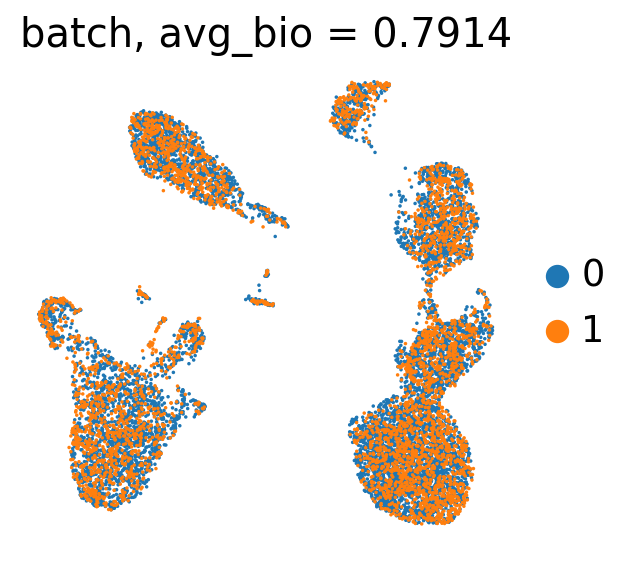

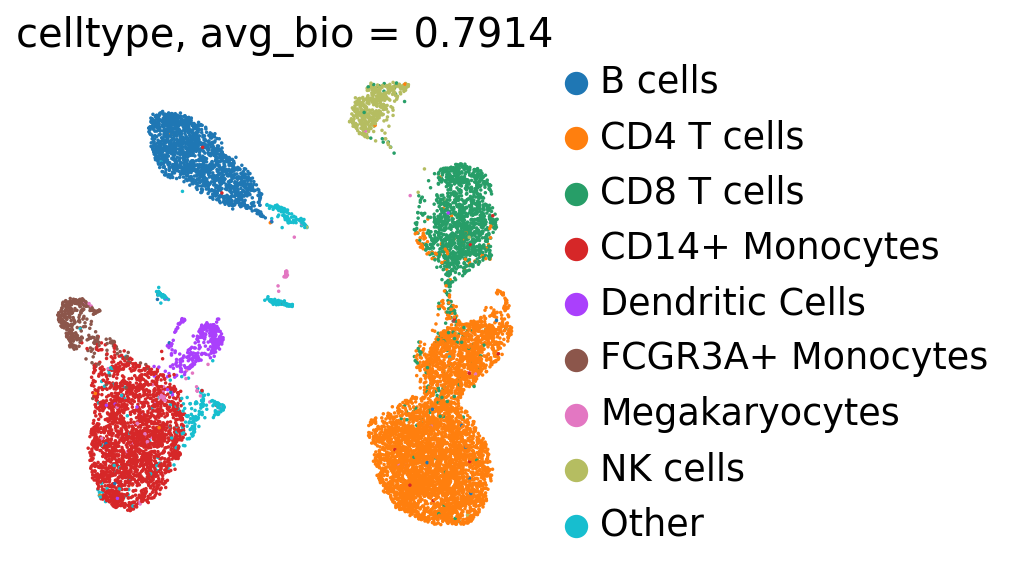

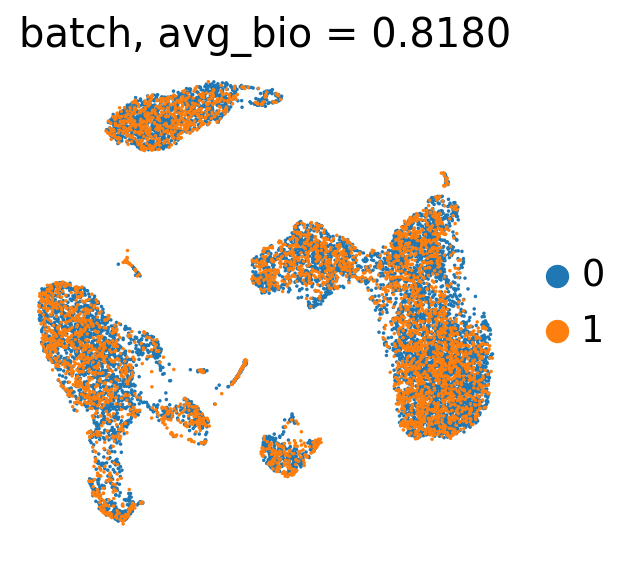

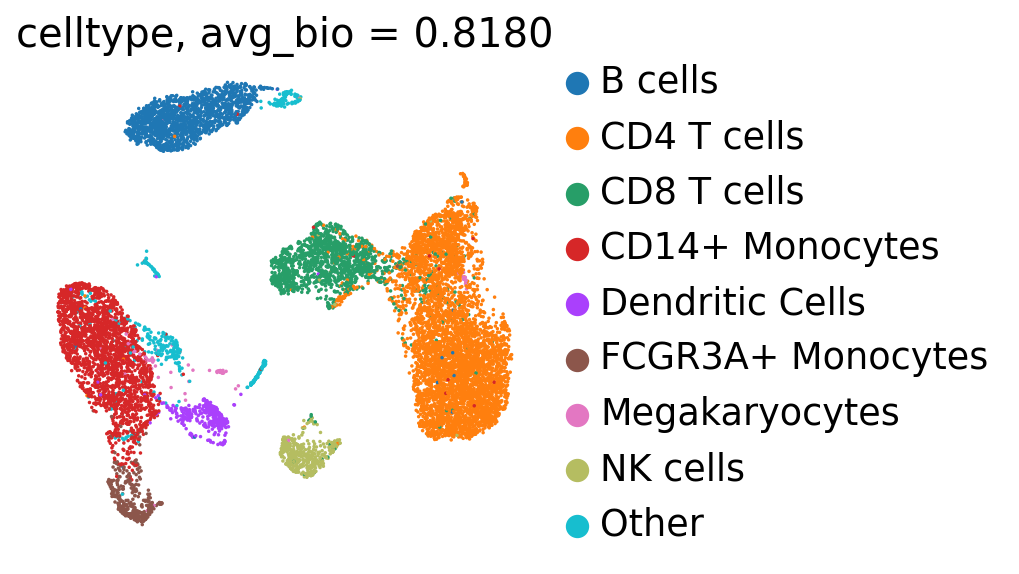

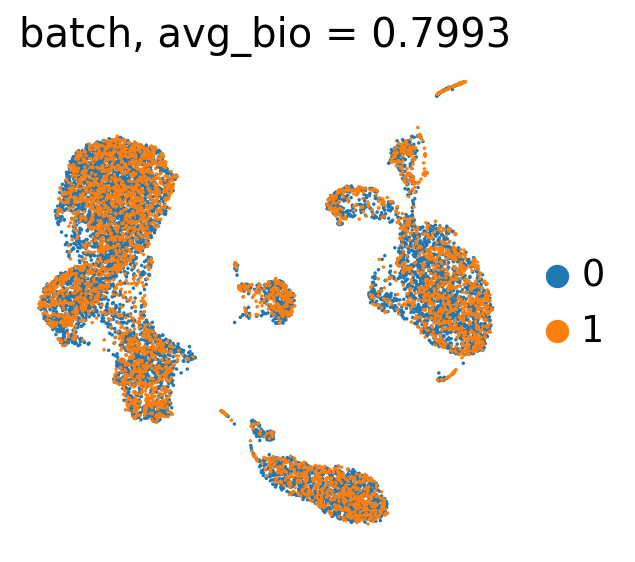

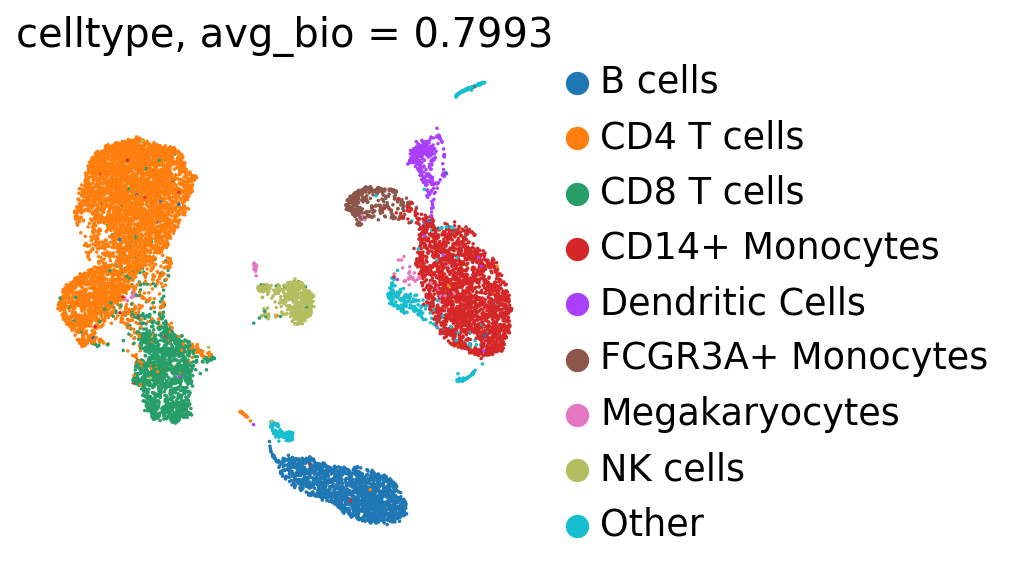

In [17]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(sort_seq_batch=per_seq_batch_sample)
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if config.do_train:
        train(
            model,
            loader=train_loader,
        )
    val_loss, val_mre = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f} | mre {val_mre:5.4f}"
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            best_model,
            adata_t=adata_sorted if per_seq_batch_sample else adata,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/best_model_epoch"] = best_model_epoch

    scheduler.step()


In [18]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")